<h1>Capstone Project - The Battle of Neighbourhoods</h1>

<h2> Introduction </h2>
Canada is one of the most popular places for immigration for Hong Kong citizens. The Chinese Canadian population has been growing since 1960s due to the changes in immigration law and political issues in Hong Kong. The Chinese has established many shops and restuarants to cater their population. As the capital of the province of Ontario, many immigrants favour Toronto as their port of entry. In this project, we would be finding the neighbourhood with the best Chinese resturants in Toronto. This would be valuable for new comers joining the community who prefer to have Chinese food.


<h2> Data </h2>
For this project we need the following data :

* **Toronto city data** that contains list Boroughs, Neighborhoods along with their latitude and longitude.
Data source : http://cocl.us/Geospatial_data, 
https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M
<br/>Description : The Wikipedia page includes the postode, borough, and neighbourhood. And geocodes will be obtained from the geospatial_data. After combination, we will use this data set to explore various neighborhoods of Toronto city.
Chinese resturants in each neighborhood of Toronto.

* **Fousquare API**
<br/>Description : By using this api we will get all the venues in each neighborhood. We can filter these venues to get only Chinese resturants.

* **City of Toronto Neighborhood Shapes for mapping**
<br/>Data source : https://www.google.com/maps/d/u/0/viewer?msa=0&mid=1uclm6-D3MSanesned1rQCnzJtws&ll=43.71277641798449%2C-79.49240235858218&z=10
<br/> Description : By using this data we will get the Toronto neighbourhood boundaries that will help us visualize choropleth map. (KML converted to geojson file)

<h2> Approach </h2>
Collect the new york city data from http://cocl.us/Geospatial_data
Using FourSquare API we will find all venues for each neighborhood.
Filter out all venues that are Chinese Resturants.
Find rating , tips and like count for each Indian Resturants using FourSquare API.
Using rating for each resturant , we will sort that data.
Visualize the Ranking of neighborhoods using folium library(python)

<h2> Analysis</h2>
We will import the required libraries for python.

pandas and numpy for handling data.
request module for using FourSquare API.
geopy to get co-ordinates of City of New York.
folium to visualize the results on a map

In [22]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
import geocoder
import os
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')

Libraries imported.


To define a function to get the latitude and longitude of a given location using geopy

In [23]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="chinesefood")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

To define a function of FourSqaure API and get top 100 venues within a radius of 500 meters for a given latitude and longitude.

In [101]:
def get_venues(lat,lng):
    
    #set variables
    radius=5000
    LIMIT=100
    CLIENT_ID = 'S4CCVGHDBUD1GJCYMFSTBIEJRNGKAI3ABY0K2QQ15TCYONLG' # your Foursquare ID
    CLIENT_SECRET = 'MDDQB3QM2Q2GRONKZC4LWPHUTYMHI3PMKAS0OOE3VAQCXWN2W' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

To define a function to obtain venue detail

In [102]:
def get_venue_details(venue_id):

    
    CLIENT_ID = 'S4CCVGHDBUD1GJCYMFSTBIEJRNGKAI3ABY0K2QQ15TCYONLG' # your Foursquare ID
    CLIENT_SECRET = 'MDDQB3QM2Q2GRONKZC4LWPHUTYMHI3PMKAS0OOE3VAQCXWN2' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    result = requests.get(url).json()

    venue_data=result['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

To obtain the data of Toronto such as borough, neighbourhoods and geocode

In [38]:
res = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
soup = BeautifulSoup(res.content,'lxml')
table = soup.find_all('table')[0] 
df = pd.read_html(str(table))[0]
postcode = df["Postcode"].tolist()
borough = df["Borough"].tolist()
neighbourhood= df["Neighbourhood"].tolist()
#removing borough that are not assigned
df = df[df.Borough != 'Not assigned'] 
#Combing neighborhood with the same postcode
df2 = pd.DataFrame({'Postcode':df.Postcode.unique()})
df2['Borough']=pd.DataFrame(list(set(df['Borough'].loc[df['Postcode'] == x['Postcode']])) for i, x in df2.iterrows())
df2['Neighbourhood']=pd.Series(list(set(df['Neighbourhood'].loc[df['Postcode'] == x['Postcode']])) for i, x in df2.iterrows())
df2['Neighbourhood']=df2['Neighbourhood'].apply(lambda x: ', '.join(x))
# replace "Not assigned" Neighborhoods with Borough
df2.Neighbourhood.replace("Not assigned", df2.Borough, inplace=True)
#add Geo-spatial data
dfll= pd.read_csv("http://cocl.us/Geospatial_data")
dfll.rename(columns={'Postal Code':'Postcode'}, inplace=True)
dfll.set_index("Postcode")
df2.set_index("Postcode")
toronto_data=pd.merge(df2, dfll)
toronto_data=toronto_data.drop('Postcode',1)
toronto_data.head()

,Borough,Neighbourhood,Latitude,Longitude
0,North York,Parkwoods,43.753259,-79.329656
1,North York,Victoria Village,43.725882,-79.315572
2,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763
4,Queen's Park,Queen's Park,43.662301,-79.389494


To evaluate the number of neighbourhoods for each borough

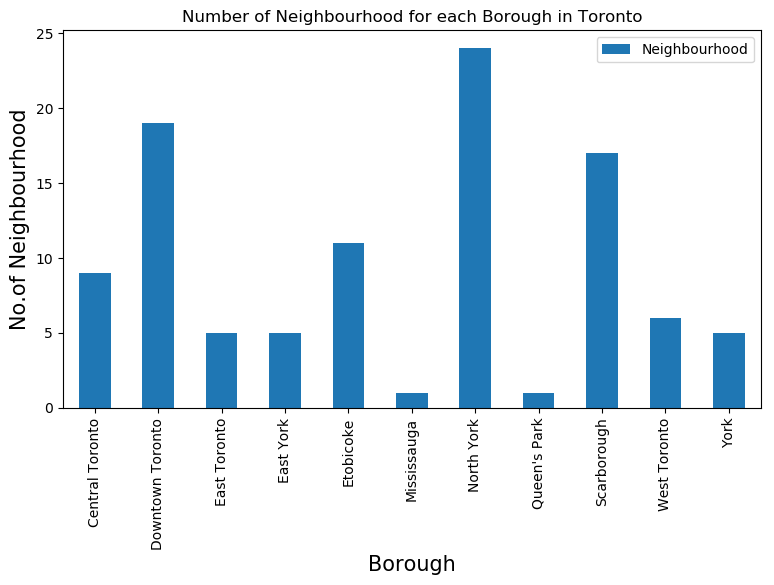

In [39]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighbourhood for each Borough in Toronto')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighbourhood', fontsize=15)
#giving a bar plot
toronto_data.groupby('Borough')['Neighbourhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We see that North York has highest number of neighborhoods

Next we will study the Chinese restuarants in each neighbourhood

In [81]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighbourhood', 'ID','Name']
chinese_restaurant_toronto=pd.DataFrame(columns=column_names)
count=1
for row in toronto_data.values.tolist():
    Borough, Neighbourhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    chinese_resturants=venues[venues['Category']=='Chinese Restaurant']   
    print('(',count,'/',len(toronto_data),')','Chinese Resturants in '+Neighbourhood+', '+Borough+':'+str(len(chinese_resturants)))
    for resturant_detail in chinese_resturants.values.tolist():
        id, name , category=resturant_detail
        chinese_restaurant_toronto = chinese_restaurant_toronto.append({'Borough': Borough,
                                                'Neighbourhood': Neighbourhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 103 ) Chinese Resturants in Parkwoods, North York:2
( 2 / 103 ) Chinese Resturants in Victoria Village, North York:1
( 3 / 103 ) Chinese Resturants in Harbourfront, Downtown Toronto:0
( 4 / 103 ) Chinese Resturants in Lawrence Heights, Lawrence Manor, North York:1
( 5 / 103 ) Chinese Resturants in Queen's Park, Queen's Park:0
( 6 / 103 ) Chinese Resturants in Queen's Park, Downtown Toronto:1
( 7 / 103 ) Chinese Resturants in Malvern, Rouge, Scarborough:2
( 8 / 103 ) Chinese Resturants in Don Mills North, North York:0
( 9 / 103 ) Chinese Resturants in Woodbine Gardens, Parkview Hill, East York:0
( 10 / 103 ) Chinese Resturants in Garden District, Ryerson, Downtown Toronto:0
( 11 / 103 ) Chinese Resturants in Glencairn, North York:0
( 12 / 103 ) Chinese Resturants in Islington, West Deane Park, Cloverdale, Princess Gardens, Martin Grove, Etobicoke:0
( 13 / 103 ) Chinese Resturants in Highland Creek, Port Union, Rouge Hill, Scarborough:1
( 14 / 103 ) Chinese Resturants in Don Mills 

In [82]:
chinese_restaurant_toronto.head()

,Borough,Neighbourhood,ID,Name
0,North York,Parkwoods,584e235102b60e2d40263821,天天渔港 Captain's Catch
1,North York,Parkwoods,5b6a321d340a58002cc0d9db,Omni Palace Noodle House
2,North York,Victoria Village,55dded07498eecf46ed3e0d9,Hakka Legend
3,North York,"Lawrence Heights, Lawrence Manor",4e11fd03b61c637b97b2386e,Hakka No. 1
4,Downtown Toronto,Queen's Park,4c0bf5f5ffb8c9b6010b6e61,Mayflower Chinese Food


In [83]:
chinese_restaurant_toronto.shape

(124, 4)

There are 124 Chinese resturants in Toronto

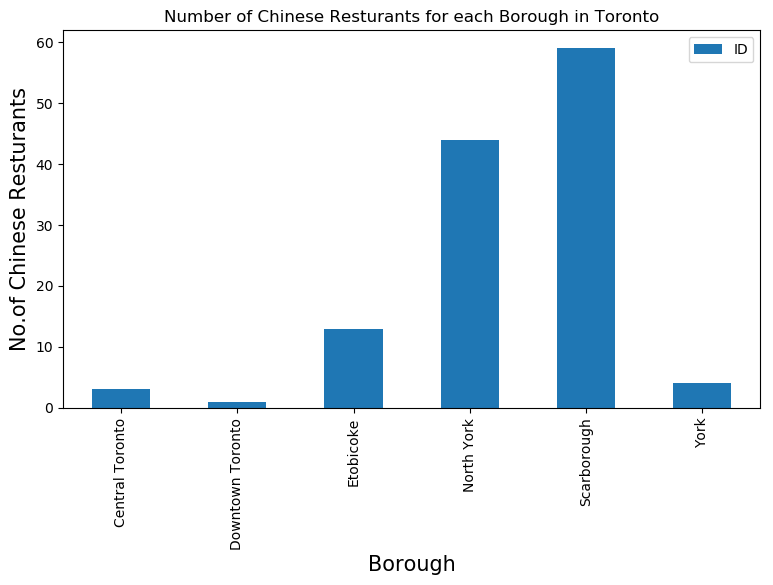

In [84]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Chinese Resturants for each Borough in Toronto')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Chinese Resturants', fontsize=15)
#giving a bar plot
chinese_restaurant_toronto.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

Scarborough is the borough with the largest number of Chinese resturants in Toronto

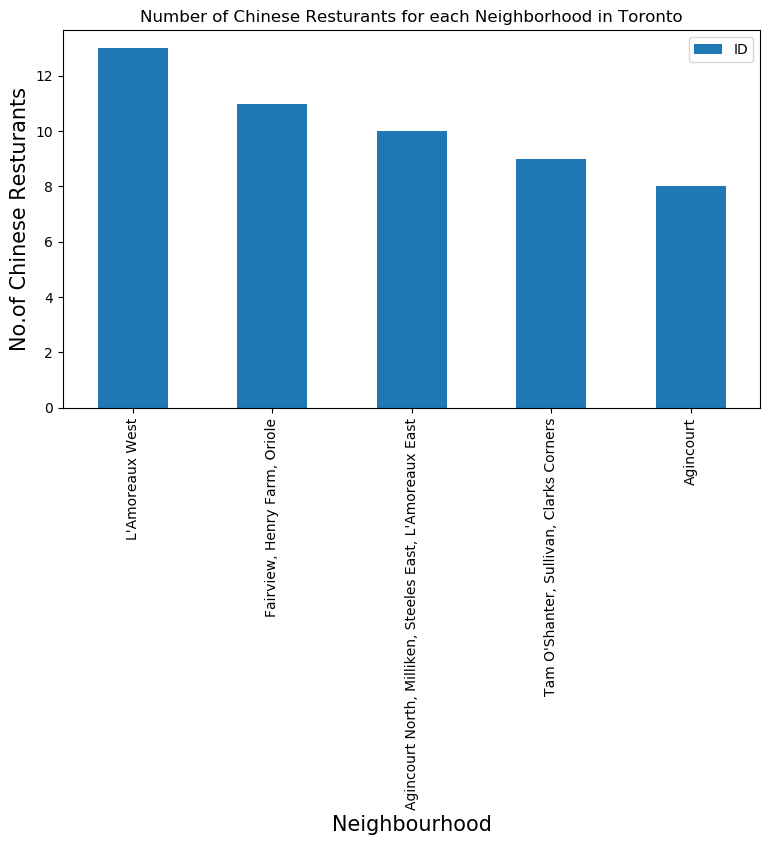

In [85]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Chinese Resturants for each Neighborhood in Toronto')
#On x-axis
plt.xlabel('Neighbourhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Chinese Resturants', fontsize=15)
#giving a bar plot
chinese_restaurant_toronto.groupby('Neighbourhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [53]:
chinese_restaurant_toronto[chinese_restaurant_toronto['Neighbourhood']=="L'Amoreaux West"]

,Borough,Neighbourhood,ID,Name
107,Scarborough,L'Amoreaux West,5aa5a8c85f68b930df32dc53,Fishman Lobster Clubhouse Restaurant 魚樂軒
108,Scarborough,L'Amoreaux West,4c1b6f35b4e62d7f3951d993,D&R Wings 美華茶餐廳
109,Scarborough,L'Amoreaux West,4babe7aaf964a520efd33ae3,Asian Legend 味香村
110,Scarborough,L'Amoreaux West,58c1e6e801f4336e21f31b50,Yin Ji Chang Fen 銀記腸粉店
111,Scarborough,L'Amoreaux West,4bb6338c1344b7131d229d04,Sun's Kitchen 拉麵王
112,Scarborough,L'Amoreaux West,584e235102b60e2d40263821,天天渔港 Captain's Catch
113,Scarborough,L'Amoreaux West,4cdc8e53d4ecb1f7843c8048,The Royal Chinese Restaurant 避風塘小炒
114,Scarborough,L'Amoreaux West,5b634b5f95a722002c977b3e,Sam's Congee Delight 黃三記
115,Scarborough,L'Amoreaux West,4ae66ccbf964a520eba621e3,Congee Wong 天皇名粥
116,Scarborough,L'Amoreaux West,4ceea52a7db3224b4ddb282e,Chinese Halal Restaurant 中華牛羊館


L'Amoreaux West is the neighbourhood with the largest number of Chinese resturants of 13.

Next we would assess the ranking of each Chinese restuarant

In [168]:
# prepare neighborhood list that contains Chinese resturants
column_names=['Borough', 'Neighbourhood', 'ID','Name','Likes','Rating','Tips']
chinese_restaurant_toronto_stats=pd.DataFrame(columns=column_names)
count=1

get_venue_details(ID)

for row in chinese_restaurant_toronto.values.tolist():
    Borough,Neighbourhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(chinese_restaurant_toronto),')','processed')
    chinese_restaurant_toronto_stats = chinese_restaurant_toronto_stats.append({'Borough': Borough,
                                                'Neighbourhood': Neighbourhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

KeyError: 'venue'

In [104]:
chinese_restaurant_toronto_stats.head()

,Borough,Neighbourhood,ID,Name,Likes,Rating,Tips


The above data would be saved to a csv file for futher manupulation
(As the number of premium calls are limited in FourSquare using Sandbox account)

In [57]:
chinese_restaurant_toronto_stats.to_csv('chinese_restaurant_toronto_stats.csv', index=False)

In [111]:
chinese_restaurant_toronto_stats_csv=pd.read_csv('chinese_restaurant_toronto_stats.csv')
chinese_restaurant_toronto_stats_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips,Neighbourhood
0,North York,NaN,584e235102b60e2d40263821,天天渔港 Captain's Catch,7,7.7,3,Parkwoods
1,North York,NaN,5b6a321d340a58002cc0d9db,Omni Palace Noodle House,7,7.4,3,Parkwoods
2,North York,NaN,55dded07498eecf46ed3e0d9,Hakka Legend,7,7.5,0,Victoria Village
3,North York,NaN,4e11fd03b61c637b97b2386e,Hakka No. 1,10,7.3,3,"Lawrence Heights, Lawrence Manor"
4,Downtown Toronto,NaN,4c0bf5f5ffb8c9b6010b6e61,Mayflower Chinese Food,7,7.1,5,Queen's Park


In [ ]:
chinese_restaurant_toronto_stats_csv.info()

In [106]:
# Resturant with maximum Likes
chinese_restaurant_toronto_stats_csv.iloc[chinese_restaurant_toronto_stats_csv['Likes'].idxmax()]

Borough                        North York
Neighborhood                          NaN
ID               4ae66ccbf964a520eba621e3
Name                     Congee Wong 天皇名粥
Likes                                  60
Rating                                  8
Tips                                   40
Neighbourhood           Hillcrest Village
Name: 11, dtype: object

In [107]:
# Resturant with maximum rating
chinese_restaurant_toronto_stats_csv.iloc[chinese_restaurant_toronto_stats_csv['Rating'].idxmax()]

Borough                                        North York
Neighborhood                                          NaN
ID                               5aa5a8c85f68b930df32dc53
Name             Fishman Lobster Clubhouse Restaurant 魚樂軒
Likes                                                  33
Rating                                                8.7
Tips                                                    8
Neighbourhood                Fairview, Henry Farm, Oriole
Name: 26, dtype: object

In [108]:
# Resturant with maximum tips
chinese_restaurant_toronto_stats_csv.iloc[chinese_restaurant_toronto_stats_csv['Tips'].idxmax()]

Borough                        North York
Neighborhood                          NaN
ID               4ae66ccbf964a520eba621e3
Name                     Congee Wong 天皇名粥
Likes                                  60
Rating                                  8
Tips                                   40
Neighbourhood           Hillcrest Village
Name: 11, dtype: object

We would then visualise the neighbourhood with the maximum average rating

In [113]:
toronto_neighborhood_stats=chinese_restaurant_toronto_stats_csv.groupby('Neighbourhood',as_index=False).mean()[['Neighbourhood','Rating']]
toronto_neighborhood_stats.columns=['Neighbourhood','Average Rating']

In [114]:
toronto_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighbourhood,Average Rating
15,"Silver Hills, York Mills",7.950000
3,"Fairview, Henry Farm, Oriole",7.836364
0,Bayview Village,7.825000
5,Hillcrest Village,7.825000
6,Humber Summit,7.700000
12,Parkwoods,7.550000
1,Cedarbrae,7.550000
11,"Oakridge, Clairlea, Golden Mile",7.500000
16,Victoria Village,7.500000
2,"Downsview, Upwood Park, North Park",7.300000


The top neighbourhoods with top average rating of Chinese resturants

In [115]:
toronto_borough_stats=chinese_restaurant_toronto_stats_csv.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
toronto_borough_stats.columns=['Borough','Average Rating']

In [116]:
toronto_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
1,North York,7.768750
0,Downtown Toronto,7.100000
2,Scarborough,6.983333


The top boroughs with top average rating of Chinese resturants

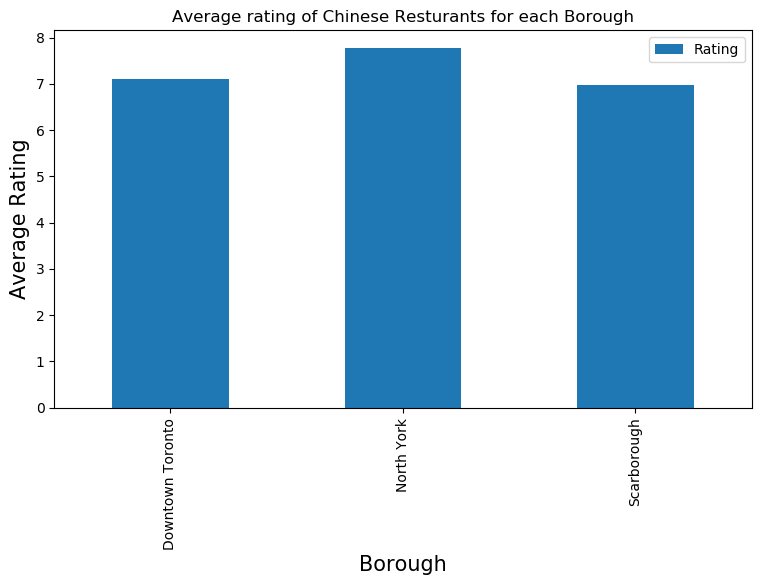

In [117]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Chinese Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
chinese_restaurant_toronto_stats_csv.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

North York has the highest average rating of Chinese resturants

We are going to plot all the neighbourhoods with average rating greater than 7.5

In [123]:
toronto_neighbour_selected=toronto_neighborhood_stats[toronto_neighborhood_stats['Average Rating']>=7.5]

In [124]:
toronto_neighbour_selected

,Neighbourhood,Average Rating
0,Bayview Village,7.825000
1,Cedarbrae,7.550000
3,"Fairview, Henry Farm, Oriole",7.836364
5,Hillcrest Village,7.825000
6,Humber Summit,7.700000
11,"Oakridge, Clairlea, Golden Mile",7.500000
12,Parkwoods,7.550000
15,"Silver Hills, York Mills",7.950000
16,Victoria Village,7.500000


Next we would merge the dataset with the geodata

In [125]:
toronto_neighbour_selected_merged=pd.merge(toronto_neighbour_selected,toronto_data, on='Neighbourhood')
toronto_neighbour_selected_merged=toronto_neighbour_selected_merged[['Borough','Neighbourhood','Latitude','Longitude','Average Rating']]

In [126]:
toronto_neighbour_selected_merged

,Borough,Neighbourhood,Latitude,Longitude,Average Rating
0,North York,Bayview Village,43.786947,-79.385975,7.825000
1,Scarborough,Cedarbrae,43.773136,-79.239476,7.550000
2,North York,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,7.836364
3,North York,Hillcrest Village,43.803762,-79.363452,7.825000
4,North York,Humber Summit,43.756303,-79.565963,7.700000
5,Scarborough,"Oakridge, Clairlea, Golden Mile",43.711112,-79.284577,7.500000
6,North York,Parkwoods,43.753259,-79.329656,7.550000
7,North York,"Silver Hills, York Mills",43.757490,-79.374714,7.950000
8,North York,Victoria Village,43.725882,-79.315572,7.500000


Finally its time to plot them on a map!

In [153]:
toronto_map = folium.Map(location=geo_location('Toronto'), zoom_start=9)

In [154]:
neighbourpoint = folium.map.FeatureGroup()

for lat, lng, in toronto_neighbour_selected_merged[['Latitude','Longitude']].values:
    neighbourpoint .add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [155]:

toronto_neighbour_selected_merged['Label']=toronto_neighbour_selected_merged['Neighbourhood']+', '+toronto_neighbour_selected_merged['Borough']+'('+toronto_neighbour_selected_merged['Average Rating'].map(str)+')'

In [156]:

# add pop-up text to each marker on the map
for lat, lng, label in toronto_neighbour_selected_merged[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(toronto_map)        
# add neighbours to map
neighbourpoint.add_child(neigh)


In [157]:
toronto_map

In [176]:
toronto_map_2 = folium.Map(location=geo_location('Toronto'), zoom_start=10)
toronto_geo = r'https://raw.githubusercontent.com/ckmfong/github-example/master/Neighbourhoods.geojson'

toronto_map_2.choropleth(
    geo_data=toronto_geo,
    data=toronto_neighbour_selected_merged,
    columns=['Neighbourhood', 'Average Rating'],
    key_on='feature.properties.AREA_NAME',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating of Chinese restaruants'
)
toronto_map_2